# Block Slide Example

Here we simulate a rigid block (point mass) sliding down a slope.

In [1]:
using LaTeXStrings
using LinearAlgebra
using ProgressMeter # Utility for displaying progress
using Plots
using Optim
#theme(:juno)

The block has mass $m > 0$ and the slope makes $\theta > 0$ radians with the horizontal.

The goal of this example is to evaluate how integrators can affect the stopping distance when the block experiences friction forces.

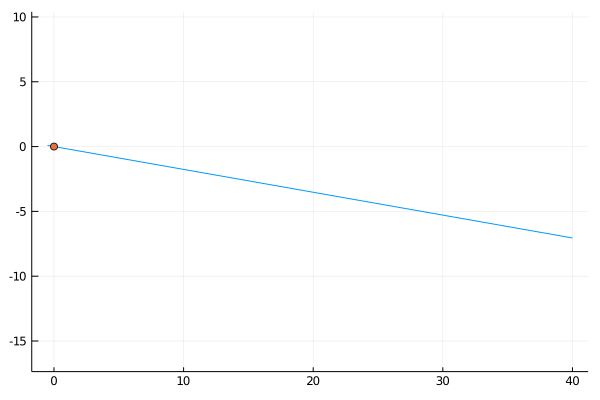

In [2]:
θ = 10*pi/180
plot([-0.5,40], [0.5*tan(θ), -40*tan(θ)], aspect_ratio=1, legend=false)
scatter!([0], [0])

The equations of motion on the block can be written as:
$$
    m\ddot{q} = f_g + f_f
$$
where $f_g$ is the force of gravity and $f_f$ is friction. This is formualted as a 1D problem since the block will always be resting on the slope. In other words, gravity and normal forces are known to be perfectly balanced. This means that $q$ is the single degree of freedom indicating where the block is located at any point in time along the slope. More precisely we can define the world space position of the mass in terms of $q$:
$$
    p = (q \cos(\theta), -q \sin(\theta)) \in \mathbb{R}^2
$$


The force of gravity
$$
    f_g = mg\sin(\theta)
$$
where $g=9.81\mathrm{m}/\mathrm{s}^2$. 
Consequently, friction force (assuming Coulomb friction) is proportional to $f_c$ and has the form:
$$
    f_f \in -\mu mg \cos(\theta)\,B(\dot{q})
$$
where $\mu > 0$ is the proportionality coefficient or the "coefficient of friction" and
$$
B(x) = \left\{
\begin{array}{ll}
-1 & \text{if}\ x < 0 \\
[-1, 1] & \text{if}\ x = 0 \\
1 & \text{if}\ x > 0
\end{array}\right.
$$

Expanding the net force equation, we get:
$$
    m\ddot{q} \in mg\sin(\theta) - \mu mg\cos(\theta)\, B(\dot{q}) \tag{1}
$$

We can rewrite equation (11) more simply as
$$
\begin{align}
    \ddot{q} &\in \sin(\theta) - \mu \cos(\theta)\,B(\dot{q}) \tag{2}
\end{align}
$$

## Smooth Friction

As in the Rod Spring example, we will use a smoothed friction model, which we denote by $\tilde{B}(x, \epsilon)$, where $\tilde{B}(\cdot, \epsilon) \to B$ as $\epsilon \to 0$ pointwise a.e.

In [3]:
function B2(x, eps)
    if x < -eps
        -1
    elseif x > eps
        1
    elseif x < 0
        2*x/eps + x*x/(eps*eps)
    else
        2*x/eps - x*x/(eps*eps)
    end
end;
function B1(x, eps)
    if x < -eps
        -1
    elseif x > eps
        1
    else
        x/eps
    end
end;

# Problem Definition

Below we define the necessary quantities for solving the problem in equation (1).

In [4]:
Base.@kwdef mutable struct BlockSlide
    h::Float64 = 0.025
    q::Float64 = 0
    v::Float64 = 1
    µ::Float64 = 0.1
    ε::Float64 = 0.01
    θ::Float64 = 10*pi/180
end;

world(r::BlockSlide) = [r.q*cos(r.θ), -r.q*sin(r.θ)];

We can rewrite equation (1) in terms of position $q$ and velocity $v$ forming a first order ODE:
$$
\begin{align}
    \dot{q} &= v \\
    \dot{v} &= \sin(\theta) - \mu \cos(\theta)\,\tilde{B}(v) \tag{3}
\end{align}
$$
where we used the smoothed friction approximation $\tilde{B}$.

## Forward Euler

Bellow we will demonstrate FE applied to the problem in equation (3):

$$
\begin{align}
q_+ &= q + hv \\
v_+ &= v + h(\sin(\theta) - \mu \cos(\theta)\,\tilde{B}(v))
\end{align}
$$
where $h$ is the time step.

In [5]:
function fe_step!(r::BlockSlide)
    μ = r.μ
    v = r.v
    ε = r.ε
    h = r.h
    q = r.q
    θ = r.θ
    
    dv = sin(θ) - μ*cos(θ)*B1(v, ε)
    v = v + h * dv
    r.q = q + h * r.v
    r.v = v;
end;

In [6]:
@userplot BlockPlot
@recipe function f(rp::BlockPlot)
    r = rp.args[1]
    extent = 40
    aspect_ratio := 1
    xlims --> [-0.5,extent]
    legend := false
    [-0.5,extent], [0.5*tan(r.θ), -extent*tan(r.θ)]
end

In [7]:
substeps = 5; # steps per frame
h = 0.01; # time step
T = 100; # total seconds

In [8]:
r = BlockSlide(
    h=h,
    μ=0.2
);
frames = Int(T/h)
progress = Progress(frames)
anim = @animate for i = 1:frames
    fe_step!(r)
    plt = blockplot(r)
    p = world(r)
    scatter!(plt, [p[1]], [p[2]])
    next!(progress)
end every substeps*20
mp4(anim, "fe_m02.mp4", fps = (1.0/h)/substeps)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
┌ Info: Saved animation to 
│   fn = /home/egor/proj/julia-experiments/Rod Spring/fe_m02.mp4
└ @ Plots /home/egor/.julia/packages/Plots/JKY3H/src/animation.jl:104


Plots.AnimatedGif("/home/egor/proj/julia-experiments/Rod Spring/fe_m02.mp4")

In [9]:
r.q

21.957033338198034

## Backward Euler

Bellow we will demonstrate BE applied to the problem in equation (3):

$$
\begin{align}
q_+ &= q + hv_+ \\
v_+ &= v + h(\sin(\theta) - \mu \cos(\theta)\,\tilde{B}(v_+))
\end{align}
$$
where $h$ is the time step.

Equivalently we can plug in the first equation into the second to create a velocity problem followed by a simple position increment:
$$
\begin{align}
v_+ &= v + h(\sin(\theta) - \mu \cos(\theta)\,\tilde{B}(v_+)) \tag{4a} \\
q_+ &= q + hv_+ \tag{4b} \\
\end{align}
$$

### Using Optimization

Since equation (4a) is an implicit solve, we can convert it into an optimization by observing that $\tilde{B}$ can be derived from a smooth potential as in the Rod Spring example:
$$
\tilde{B}_2(x) = \frac{\partial\tilde{b}_2(x)}{\partial x} \\
\tilde{b}_2(x) = \left\{
\begin{array}{ll}
-x - \frac{\epsilon}{3} & \text{if}\ x < -\epsilon \\
x - \frac{\epsilon}{3} & \text{if}\ x > \epsilon \\
\frac{x^2}{\epsilon} + \frac{x^3}{3\epsilon^2} & \text{if}\ x \in [-\epsilon, 0] \\
\frac{x^2}{\epsilon} - \frac{x^3}{3\epsilon^2} & \text{if}\ x \in (0, \epsilon]
\end{array}
\right.
$$

In [10]:
function Ψ(u::Float64, r::BlockSlide)
    0.5*u^2 - r.l0*sqrt(u^2 + 1)
end
function b2(x::Float64, eps::Float64)
    if x < -eps
        -x - eps/3
    elseif x > eps
        x - eps/3
    elseif x < 0
        x*x/eps + x*x*x/(3*eps*eps)
    else
        x*x/eps - x*x*x/(3*eps*eps)
    end
end;

We can then write equation (4a) as a minimization and use a black-box optimization tool to solve the following problem:
$$
\begin{align}
v_+ &= \mathrm{argmin}_{u} f(u) \tag{5a} \\
f(u) &= \frac{1}{2} (u - v)^2 - h\sin(\theta)u + h\mu \cos(\theta) \tilde{b}_2(u) \tag{5b}
\end{align}
$$

In [11]:
function f(u::Float64, r::BlockSlide)
    v = r.v
    h = r.h
    q = r.q
    μ = r.μ
    ε = r.ε
    θ = r.θ
    
    0.5*(u - v)^2 - h*sin(θ)*u + h*μ*cos(θ)*b2(u, ε)
end;

In [12]:
function be_opt_step!(r::BlockSlide)
    result = optimize(u -> f(u[1], r), [0.0], LBFGS())
    v = Optim.minimizer(result)
    r.v = v[1]
    r.q = r.q + r.h*r.v
end;

Below we simulate the same test as our previous FE example able.

In [13]:
T = 100;
h = 0.01;
r = BlockSlide(
    h=h,
    μ=0.2
);
frames = Int(T/h)
progress = Progress(frames)
anim = @animate for i = 1:frames
    be_opt_step!(r)
    plt = blockplot(r)
    p = world(r)
    scatter!(plt, [p[1]], [p[2]])
    next!(progress)
    end every substeps*20
mp4(anim, "be_m02.mp4", fps = (1.0/h)/substeps)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
┌ Info: Saved animation to 
│   fn = /home/egor/proj/julia-experiments/Rod Spring/be_m02.mp4
└ @ Plots /home/egor/.julia/packages/Plots/JKY3H/src/animation.jl:104


Plots.AnimatedGif("/home/egor/proj/julia-experiments/Rod Spring/be_m02.mp4")

In [14]:
r.q

21.817574962984416